In [1]:
#Importing Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import mean_squared_error,r2_score
import openpyxl
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
mintemp=pd.read_csv("C:\\Users\\C KIRANMAYI\\Downloads\\2020Yield\\Phase 1\\csv\\min_temperature.csv")

In [3]:
mintemp

,Year,Month,past,pasttopast,min_temperature
0,1990,1,19.235625,19.451875,18.140000
1,1990,2,18.801250,19.155625,19.958125
2,1990,3,20.866250,23.768125,23.978125
3,1990,4,23.826875,25.146250,25.709375
4,1990,5,25.956250,26.014375,25.622500
...,...,...,...,...,...
355,2019,8,24.978750,24.631875,24.339375
356,2019,9,24.379375,24.057500,24.427500
357,2019,10,22.936875,24.221875,24.018125
358,2019,11,21.325000,22.667500,23.411875


In [4]:
mintemp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             360 non-null    int64  
 1   Month            360 non-null    int64  
 2   past             360 non-null    float64
 3   pasttopast       360 non-null    float64
 4   min_temperature  360 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 14.2 KB


In [5]:
#Creating correlation for precipitation
#Creating the correlation matrix for the features
corr_matrix=mintemp.corr()
corr_matrix

,Year,Month,past,pasttopast,min_temperature
Year,1.000000e+00,2.844429e-15,0.065018,0.068725,0.079068
Month,2.844429e-15,1.000000e+00,0.089041,0.082964,0.087007
past,6.501797e-02,8.904091e-02,1.000000,0.887971,0.884927
pasttopast,6.872530e-02,8.296360e-02,0.887971,1.000000,0.904571
min_temperature,7.906817e-02,8.700711e-02,0.884927,0.904571,1.000000


In [6]:
mask = np.zeros_like(corr_matrix, dtype=np.bool_)
mask[np.triu_indices_from(mask)]= True

c:\Users\C KIRANMAYI\anaconda3\envs\myenv\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


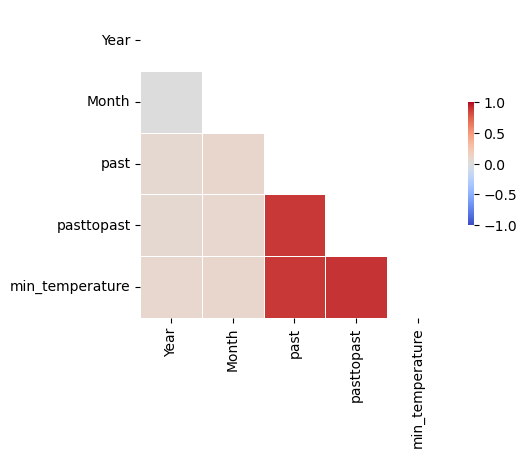

In [7]:
f, ax = plt.subplots(figsize=(5, 4)) 
heatmap = sns.heatmap(corr_matrix, mask = mask,square = True,linewidths = .5, cmap = 'coolwarm', cbar_kws = {'shrink': .4, 'ticks' : [-1, -.5, 0, 0.5, 1]},vmin = -1, vmax = 1,annot = True,annot_kws = {'size': 12})
#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [8]:
mintemp=mintemp.drop(['Year','Month'],axis=1)

In [9]:
mintemp.shape

(360, 3)

In [10]:
X=mintemp.drop('min_temperature',axis=1)
y=mintemp.min_temperature

In [11]:
X

,past,pasttopast
0,19.235625,19.451875
1,18.801250,19.155625
2,20.866250,23.768125
3,23.826875,25.146250
4,25.956250,26.014375
...,...,...
355,24.978750,24.631875
356,24.379375,24.057500
357,22.936875,24.221875
358,21.325000,22.667500


In [12]:
y

0      18.140000
1      19.958125
2      23.978125
3      25.709375
4      25.622500
         ...    
355    24.339375
356    24.427500
357    24.018125
358    23.411875
359    21.856250
Name: min_temperature, Length: 360, dtype: float64

In [13]:
X.shape

(360, 2)

In [14]:
y.shape

(360,)

In [15]:
# Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshaping data for LSTM/GRU/RNN (samples, timesteps, features)
X_scaled = np.reshape(X_scaled, (X_scaled.shape[0], X_scaled.shape[1], 1))

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

# GRU

In [16]:
def create_gru_model(units=64):
    model = Sequential()
    model.add(GRU(units=units, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    return model

In [17]:
gru_model = KerasRegressor(build_fn=create_gru_model, verbose=0)

C:\Users\C KIRANMAYI\AppData\Local\Temp\ipykernel_19360\2098133132.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  gru_model = KerasRegressor(build_fn=create_gru_model, verbose=0)


In [18]:
# Define the hyperparameter grid
gru_param_grid = {
    'units': [32, 64, 128],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

In [19]:
gru_grid = GridSearchCV(estimator=gru_model, param_grid=gru_param_grid, cv=3, scoring='neg_mean_squared_error')

In [20]:
gru_grid_result = gru_grid.fit(X_train, y_train)

In [21]:
print(f"Best GRU params: {gru_grid_result.best_params_}")
print(f"Best GRU score: {gru_grid_result.best_score_}")

Best GRU params: {'batch_size': 16, 'epochs': 100, 'units': 128}
Best GRU score: -1.2538550200742347


# LSTM

In [22]:
def create_lstm_model(units=64):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    return model

In [23]:
lstm_model = KerasRegressor(build_fn=create_lstm_model, verbose=0)

C:\Users\C KIRANMAYI\AppData\Local\Temp\ipykernel_19360\1916978622.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = KerasRegressor(build_fn=create_lstm_model, verbose=0)


In [24]:
# Define the hyperparameter grid
lstm_param_grid = {
    'units': [32, 64, 128],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

In [25]:
lstm_grid = GridSearchCV(estimator=lstm_model, param_grid=lstm_param_grid, cv=3, scoring='neg_mean_squared_error')

In [26]:
lstm_grid_result = lstm_grid.fit(X_train, y_train)

In [27]:
print(f"Best LSTM params: {lstm_grid_result.best_params_}")
print(f"Best LSTM score: {lstm_grid_result.best_score_}")

Best LSTM params: {'batch_size': 16, 'epochs': 100, 'units': 128}
Best LSTM score: -1.2660326695466633


# RNN

In [28]:
def create_rnn_model(units=64):
    model = Sequential()
    model.add(SimpleRNN(units=units, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    return model

In [29]:
rnn_model = KerasRegressor(build_fn=create_rnn_model, verbose=0)

C:\Users\C KIRANMAYI\AppData\Local\Temp\ipykernel_19360\361697586.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  rnn_model = KerasRegressor(build_fn=create_rnn_model, verbose=0)


In [30]:
rnn_param_grid = {
    'units': [32, 64, 128],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

In [31]:
rnn_grid = GridSearchCV(estimator=rnn_model, param_grid=rnn_param_grid, cv=3, scoring='neg_mean_squared_error')

In [32]:
rnn_grid_result = rnn_grid.fit(X_train, y_train)

In [33]:
print(f"Best SimpleRNN params: {rnn_grid_result.best_params_}")
print(f"Best SimpleRNN score: {rnn_grid_result.best_score_}")

Best SimpleRNN params: {'batch_size': 16, 'epochs': 100, 'units': 128}
Best SimpleRNN score: -1.552426976582046


In [34]:
# Evaluating GRU model on test data
best_gru_model = gru_grid_result.best_estimator_
y_pred_gru = best_gru_model.predict(X_test)
mse_gru = mean_squared_error(y_test, y_pred_gru)


print(f"GRU Model - MSE: {mse_gru}")

# Evaluating LSTM model on test data
best_lstm_model = lstm_grid_result.best_estimator_
y_pred_lstm = best_lstm_model.predict(X_test)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)


print(f"LSTM Model - MSE: {mse_lstm}")

# Evaluating SimpleRNN model on test data
best_rnn_model = rnn_grid_result.best_estimator_
y_pred_rnn = best_rnn_model.predict(X_test)
mse_rnn = mean_squared_error(y_test, y_pred_rnn)


print(f"SimpleRNN Model - MSE: {mse_rnn}")


GRU Model - MSE: 0.6791981921695204
LSTM Model - MSE: 0.6845988914566009
SimpleRNN Model - MSE: 0.7745831988627986


## GRU is sutaible for MinTemperature with least MSE

In [35]:
mintemp2021=pd.read_csv("C:\\Users\\C KIRANMAYI\\Downloads\\2020Yield\\Phase 1\\csv\\2020\\min_temperature.csv")

In [36]:
mintemp2021=mintemp2021.drop(['Year','Month'],axis=1)

In [37]:
mintemp2021

,past,pasttopast
0,19.186250,18.968125
1,21.694375,18.678750
2,23.441250,21.164375
3,25.480625,25.432500
4,26.908125,25.942500
5,26.970625,25.387500
6,25.253750,25.298750
7,24.339375,24.978750
8,24.427500,24.379375
9,24.018125,22.936875


In [38]:
mintemp2020_pred=[]

In [39]:
mintemp2021_scaled = scaler.transform(mintemp2021)

# Reshape for prediction
mintemp2021_scaled = np.reshape(mintemp2021_scaled, (mintemp2021_scaled.shape[0], mintemp2021_scaled.shape[1], 1))

In [40]:
best_model = gru_grid_result.best_estimator_
mintemp2020_pred=best_model.predict(mintemp2021_scaled)

In [41]:
mintemp2020_pred

array([19.438152, 21.731535, 23.42672 , 25.138367, 25.867313, 25.847424,
       25.005718, 24.45808 , 24.444283, 24.028477, 23.427372, 22.020187],
      dtype=float32)

In [42]:
mintemp_data=pd.DataFrame(data=mintemp2020_pred)
mintemp_data

,0
0,19.438152
1,21.731535
2,23.426720
3,25.138367
4,25.867313
5,25.847424
6,25.005718
7,24.458080
8,24.444283
9,24.028477


In [43]:
mintemp_data.to_csv("C:\\Users\\C KIRANMAYI\\Downloads\\2020Yield\\Phase 1\\csv\\2020\\min_temperature1.csv")